## 神经网络的学习过程
 - 从输入开始，通过训练数据在网络中正向传播生成输出
 - 基于网络的输出，用代价函数来计算想要最小化的误差
 - 反向传播误差，匹配网络中相应的权重结果并更新模型
 - 用正向传播计算网络的输出，并用阈值函数与onehot编码获得预测的分类标签

## 将多层神经网络用于mnist数据集

### 数据的读取

In [1]:
import os
import struct
import numpy as np

#path路径导入mnist数据
def load_mnist(path, kind='train'):
    
    labels_path = os.path.join(path,
                               '%s-labels.idx1-ubyte' % kind)
    
    images_path = os.path.join(path,
                               '%s-images.idx3-ubyte' % kind)
    
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('<II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)
    
    with open(images_path, 'rb') as imgpath:
        magic, n, rows, cols = struct.unpack('<IIII', imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels),784)
        images = ((images / 255.) - .5) * 2
    
    return images, labels

In [2]:
X_train, y_train = load_mnist('', kind='train')
print('Rows:%d, Columns:%d' % (X_train.shape[0], X_train.shape[1]))

Rows:60000, Columns:784


In [3]:
X_test, y_test = load_mnist('', kind='t10k')
print('Rows:%d, Columns:%d' %(X_test.shape[0],X_test.shape[1]))

Rows:10000, Columns:784


### 用matplotlib的imshow现实图像

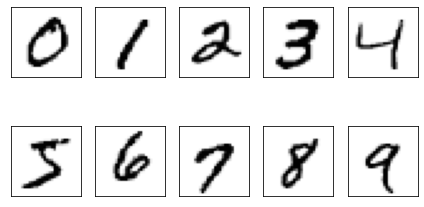

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28,28)
    ax[i].imshow(img, cmap='Greys')
    
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

### 显示4的25种样本

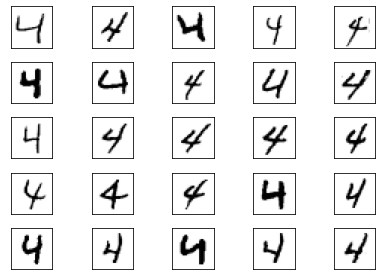

In [5]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = X_train[y_train == 4][i].reshape(28,28)
    ax[i].imshow(img, cmap='Greys')
    
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [6]:
#将缩放的数据保存起来
import numpy as np
#savez()
np.savez_compressed('mnist_scaled.npz',
                    X_train=X_train,
                    y_train=y_train,
                    X_test=X_test,
                    y_test=y_test)

In [7]:
mnist = np.load('mnist_scaled.npz')

In [8]:
mnist.files

['X_train', 'y_train', 'X_test', 'y_test']

In [9]:
X_train, y_train, X_test, y_test = [mnist[f] for f in ['X_train', 'y_train', 'X_test', 'y_test']]

In [10]:
del mnist

In [11]:
X_train.shape

(60000, 784)

In [12]:
y_train.shape

(60000,)

In [13]:
X_test.shape

(10000, 784)

In [14]:
y_test.shape

(10000,)

# 实现一个多层神经网络

In [15]:
import numpy as np
import sys


class FirstNeuralNet(object):
    
    def __init__(self, n_hidden=30, l2=0., epochs=100, eta=0.001,
                 shuffle=True, minibatch_size=1, seed=None):
        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size
    
    #将label转化成onehot编码
    def _onehot(self, y, n_classes):
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1
        return onehot.T
    
    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-np.clip(z, -250, 250)))
    
    #前向传播
    def _forward(self, X):
        #计算隐藏层的净输入
        z_h = np.dot(X, self.w_h) + self.b_h
        #隐藏层激活
        a_h = self._sigmoid(z_h)
        #计算输出层的净输入
        z_out = np.dot(a_h, self.w_out) + self.b_out
        #输出层激活
        a_out = self._sigmoid(z_out)
        return z_h, a_h, z_out, a_out
    
    #目标函数
    def _compute_cost(self, y_enc, output):
        #定义L2正则惩罚项
        L2_term = (self.l2 *
                   (np.sum(self.w_h ** 2.) + np.sum(self.w_out ** 2.)))
        
        term1 = y_enc * (np.log(output))
        term2 = (1. - y_enc) * (np.log(1. - output))
        cost = -np.sum(term1 + term2) + L2_term
        return cost
    
    def predict(self, X):
        z_h, a_h, z_out, a_out = self._forward(X)
        #对数组按列方向搜索最大值
        y_pred = np.argmax(z_out, axis=1)
        return y_pred
    
    #从训练数据中学习权重
    def fit(self, X_train, y_train, X_valid, y_valid):
        #计算样本数
        n_output = np.unique(y_train).shape[0]
        #计算特征数（784）
        n_features = X_train.shape[1]
        #初始化输入层到隐藏层的权重(scale表示方差)
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1,
                                      size=(n_features, self.n_hidden))
        #初始化隐藏层到输出层的权重
        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc=0.0, scale=0.1,
                                        size=(self.n_hidden, n_output))
        
        epoch_strlen = len(str(self.epochs))
        self.eval_ = {'cost':[], 'train_acc':[], 'valid_acc':[]}
        y_train_enc = self._onehot(y_train, n_output)
        
        for i in range(self.epochs):
            
            indices = np.arange(X_train.shape[0])
            
            if self.shuffle:
                np.random.RandomState(indices)
                
            for start_idx in range(0, indices.shape[0] - self.minibatch_size + 1, self.minibatch_size):
                
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]
                
                #前向传播
                z_h, a_h, z_out, a_out = self._forward(X_train[batch_idx])
                
                #反向传播
                delta_out = a_out - y_train_enc[batch_idx]
                sigmoid_derivative_h = a_h * (1. - a_h)
                delta_h = (np.dot(delta_out, self.w_out.T) * sigmoid_derivative_h)
                
                grad_w_h = np.dot(X_train[batch_idx].T, delta_h)
                grad_b_h = np.sum(delta_h, axis=0)
                grad_w_out = np.dot(a_h.T, delta_out)
                grad_b_out = np.sum(delta_out, axis=0)
                
                #正则化与权重更新
                delta_w_h = (grad_w_h + self.l2 * self.w_h)
                delta_b_h = grad_b_h 
                self.w_h -= self.eta * delta_w_h
                self.b_h -= self.eta * delta_b_h

                delta_w_out = (grad_w_out + self.l2 * self.w_out)
                delta_b_out = grad_b_out  
                self.w_out -= self.eta * delta_w_out
                self.b_out -= self.eta * delta_b_out
                
            #每训练一个epoch后进行评估
            z_h, a_h, z_out, a_out = self._forward(X_train)
            
            cost = self._compute_cost(y_enc=y_train_enc,
                                      output=a_out)
            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)
            
            train_acc = (np.sum(y_train == y_train_pred)).astype(float) / X_train.shape[0]
            valid_acc = (np.sum(y_valid == y_valid_pred)).astype(float) / X_valid.shape[0]
            
            sys.stderr.write('\r%0*d/%d | Cost: %.2f '
                             '| Train/Valid Acc.: %.2f%%/%.2f%% ' %
                             (epoch_strlen, i+1, self.epochs, cost,
                              train_acc*100, valid_acc*100))
            sys.stderr.flush()
            
            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)
        
        return self

In [16]:
nn = FirstNeuralNet(n_hidden=100,
                    l2=0.01,
                    epochs=200,
                    eta=0.0005,
                    minibatch_size=100,
                    shuffle=True,
                    seed=1)

nn.fit(X_train=X_train[:55000], 
       y_train=y_train[:55000],
       X_valid=X_train[55000:],
       y_valid=y_train[55000:])

200/200 | Cost: 5402.60 | Train/Valid Acc.: 99.19%/97.98%  

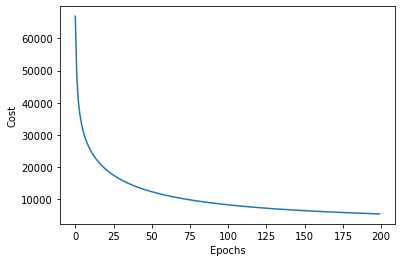

In [17]:
import matplotlib.pyplot as plt

plt.plot(range(nn.epochs), nn.eval_['cost'])
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.show()

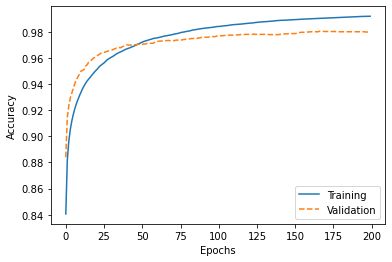

In [18]:
plt.plot(range(nn.epochs), nn.eval_['train_acc'], 
         label='Training')
plt.plot(range(nn.epochs), nn.eval_['valid_acc'], 
         label='Validation', linestyle='--')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()

In [19]:
y_test_pred = nn.predict(X_test)
acc = (np.sum(y_test == y_test_pred)).astype(float) / X_test.shape[0]

print('Test accuracy: %.2f%%' % (acc * 100))

Test accuracy: 97.54%


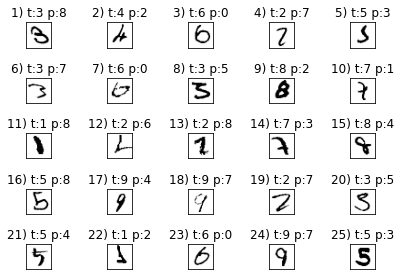

In [20]:
miscl_img = X_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab = y_test_pred[y_test != y_test_pred][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = miscl_img[i].reshape(28,28)
    ax[i].imshow(img, cmap='Greys')
    ax[i].set_title('%d) t:%d p:%d'%(i + 1, correct_lab[i], miscl_lab[i]))
    
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [21]:
import matplotlib.pyplot as plt
import cv2
img_path = "8.jpg"
img_data = cv2.imread(img_path)

ModuleNotFoundError: No module named 'cv2'

In [29]:

w_out = np.random.RandomState(1).normal(loc=0.0, scale=0.1,
                                        size=(200, 10))
w_out.shape[1]

10